# Data Exploration: Regression of Used Car Prices

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Load the dataset
cars_train_path = 'data/train.csv'
cars_train_df = pd.read_csv(cars_train_path,index_col=None)
cars_train_df.columns= cars_train_df.columns.str.lower()
cars_train_df.columns = cars_train_df.columns.str.replace(' ','_')

In [3]:
cars_train_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


## Inital Data Transformation

In [4]:
# Binary variables

#accident and clean title
cars_train_df['vehicle_damage'] = cars_train_df['accident'].map({'At least 1 accident or damage reported': 1, 'None reported': 0})

# Clean title map Yes -> 1 and Blank -> 0
cars_train_df['binary_clean_title'] = cars_train_df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

#categoric, numeric,binary

In [17]:
# Functions to extract different parts associated to the engine

# Extracting HP - Extracts digits before HP, with decimals or with no decimals
def extract_hp(value):
    match = re.search(r'(\d+\.\d+|\d+)HP', value)
    return match.group(1) if match else None
    
# Extracting Engine Size (L) - Extracts digits before L, with decimals or with no decimals
def extract_size(value):
    match = re.search(r'(\d+\.\d+|\d+)L', value)
    return match.group(1) if match else None
    
# Extracting number of cylinders - Extracts digits before Cylinder, with no decimals
def extract_cylinder(value):
    match = re.search(r'(\d+) Cylinder', value)
    return match.group(1) if match else None

def extract_fuel_type(value):
    if 'Hybrid' in value:
        return 'Hybrid'
    elif 'Electric' in value:
        return 'Electric'
    elif 'Gasoline' in value:
        return 'Gasoline'
    elif 'Diesel' in value:
        return 'Diesel'
    else:
        return 'Other'

def extract_engine_config(value):
    if 'V' in value:
        return 'V-Type'
    elif 'I' in value or 'inline' in value:
        return 'Inline'
    elif 'Flat' in value :
        return 'Flat'   
    else:
        return 'Other'
        
def extract_turbo(value):
    # Use re.IGNORECASE for case-insensitive matching
    if re.search(r'turbo', value, re.IGNORECASE):
        return 1
    else:
        return 0

In [18]:
cars_train_df['hp'] = cars_train_df['engine'].apply(extract_hp)
cars_train_df['size'] = cars_train_df['engine'].apply(extract_size)
cars_train_df['cylinder'] = cars_train_df['engine'].apply(extract_cylinder)
cars_train_df['fuel_type_2'] = cars_train_df['engine'].apply(extract_fuel_type)
cars_train_df['engine_config'] = cars_train_df['engine'].apply(extract_engine_config)
cars_train_df['turbo'] = cars_train_df['engine'].apply(extract_turbo)

In [23]:
# Functions to extract transmission type and number of speeds
# Map transmission type
def map_transmission_type(value):
    if 'M/T' in value or 'Manual' in value or 'Mt' in value:
        return 'Manual'
    elif 'A/T' in value or 'Automatic' in value or 'CVT' in value:
        return 'Automatic'
    elif 'CVT' in value:
        return 'CVT'
    elif 'Dual Shift' in value:
        return 'DCT' 
    else: 
        return 'Other'  # For any unexpected values

# Extract number of speeds
def extract_speeds(value):
    # Regular expression to find the speed number
    import re
    match = re.search(r'(\d+)-Speed', value, re.IGNORECASE)
    if match:
        return int(match.group(1))
    elif 'Single-Speed' in value or '1-Speed' in value:
        return 1
    else:
        return None  # If no speed is found


In [24]:
cars_train_df['transmission_type'] = cars_train_df['transmission'].apply(map_transmission_type)
cars_train_df['speed'] = cars_train_df['transmission'].apply(extract_speeds)

In [27]:
cars_train_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,vehicle_damage,binary_clean_title,hp,size,cylinder,fuel_type_2,engine_config,turbo,transmission_type,speed
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,0.0,1,172.0,1.6,4,Gasoline,Other,0,Automatic,NaN
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,...,1.0,1,252.0,3.9,8,Gasoline,Other,0,Automatic,NaN
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,...,0.0,1,320.0,5.3,8,Other,Other,0,Automatic,NaN
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,...,0.0,1,420.0,5.0,8,Gasoline,Other,0,DCT,NaN
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,...,0.0,1,208.0,2.0,4,Gasoline,Other,0,Automatic,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,...,0.0,1,420.0,6.2,8,Gasoline,Other,0,DCT,NaN
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,...,1.0,1,385.0,3.0,6,Gasoline,V-Type,0,Automatic,8.0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,...,0.0,1,469.0,4.0,8,Gasoline,Other,0,Automatic,7.0
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,...,0.0,0,None,3.0,None,Other,Other,0,Automatic,1.0


In [28]:
categorical_columns = ['brand', 'model', 'fuel_type','fuel_type_2','ext_col', 'int_col','engine_config', 'transmission_type',]
numeric_columns = ['model_year', 'milage','price','hp', 'size','cylinder','speed']
binary_columns = ['vehicle_damage', 'binary_clean_title','turbo']

In [36]:
cars_train_df[numeric_columns] = cars_train_df[numeric_columns].astype('float64')

Descriptive statistics for model_year:
count    188533.000000
mean       2015.829998
std           5.660967
min        1974.000000
25%        2013.000000
50%        2017.000000
75%        2020.000000
max        2024.000000
Name: model_year, dtype: float64


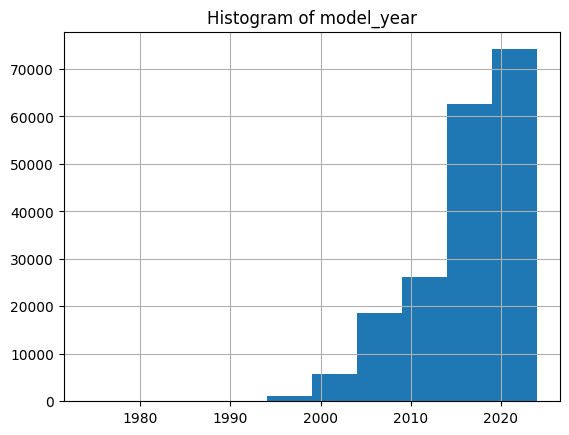

Descriptive statistics for milage:
count    188533.000000
mean      65705.295174
std       49798.158076
min         100.000000
25%       24115.000000
50%       57785.000000
75%       95400.000000
max      405000.000000
Name: milage, dtype: float64


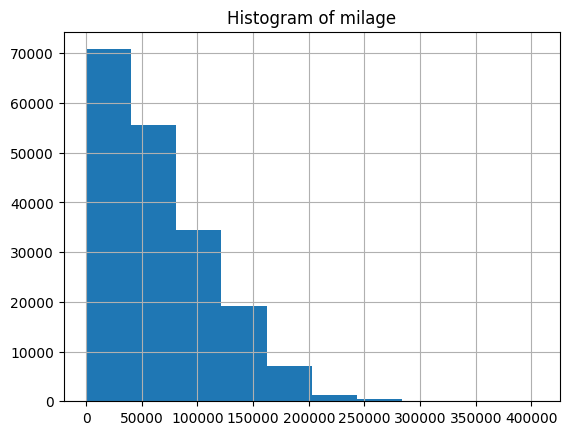

Descriptive statistics for price:
count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64


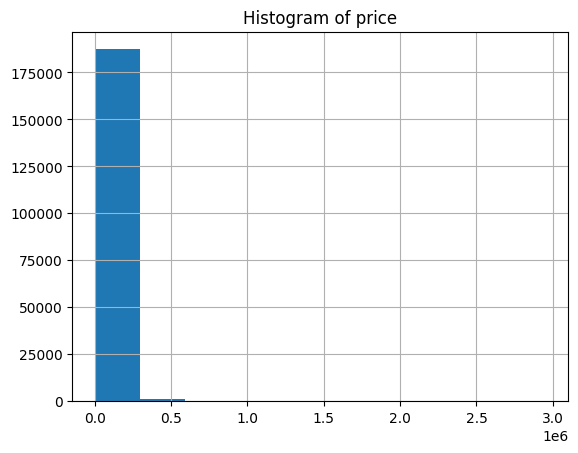

Descriptive statistics for hp:
count    155274.000000
mean        343.263856
std         114.734210
min          70.000000
25%         263.000000
50%         329.000000
75%         416.000000
max        1020.000000
Name: hp, dtype: float64


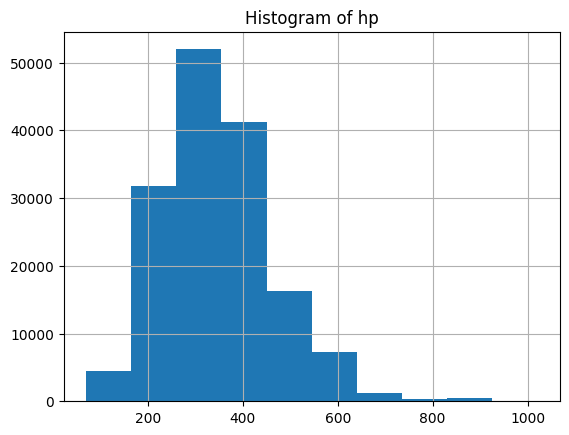

Descriptive statistics for size:
count    174319.000000
mean          3.806676
std           1.355945
min           0.650000
25%           3.000000
50%           3.500000
75%           4.800000
max           8.400000
Name: size, dtype: float64


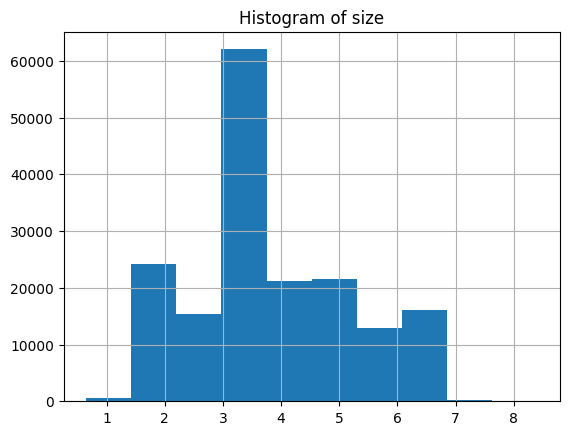

Descriptive statistics for cylinder:
count    150678.000000
mean          6.374268
std           1.554579
min           3.000000
25%           6.000000
50%           6.000000
75%           8.000000
max          12.000000
Name: cylinder, dtype: float64


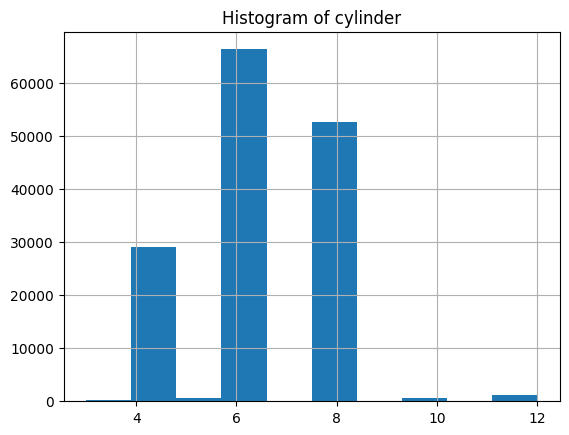

Descriptive statistics for speed:
count    104115.000000
mean          7.089584
std           1.747661
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          10.000000
Name: speed, dtype: float64


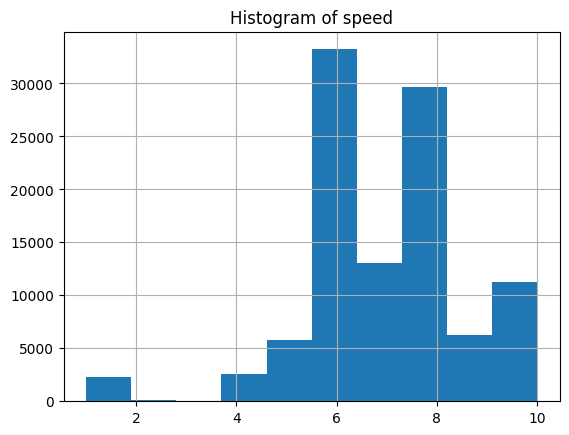

In [37]:
for col in numeric_columns:
    print(f"Descriptive statistics for {col}:")
    print(cars_train_df[col].describe())
    cars_train_df[col].hist()
    plt.title(f'Histogram of {col}')
    plt.show()

Frequency counts for brand:
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243


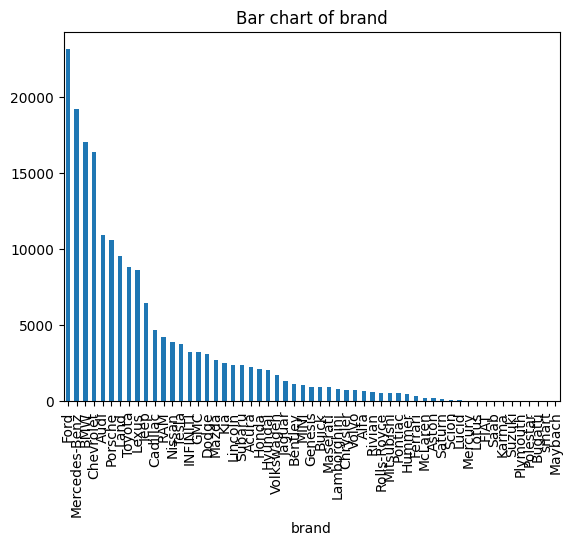

Frequency counts for model:
model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
ForTwo Pure                         2
XLR Base                            1
X5 3.0i                             1
X5 xDrive40e                        1
Integra w/A-Spec Tech Package       1
Name: count, Length: 1897, dtype: int64


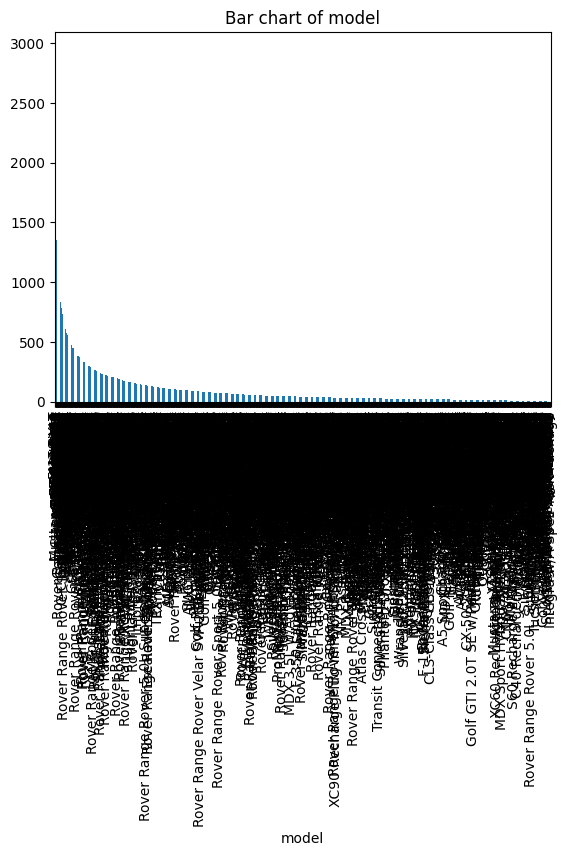

Frequency counts for fuel_type:
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64


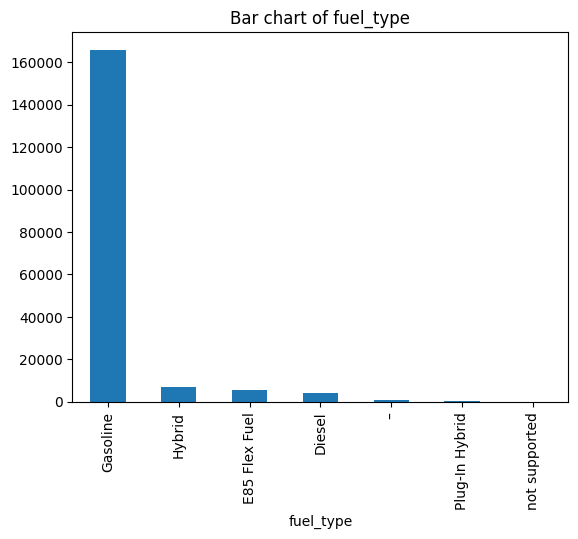

Frequency counts for fuel_type_2:
fuel_type_2
Gasoline    136161
Other        36714
Electric      6008
Hybrid        5531
Diesel        4119
Name: count, dtype: int64


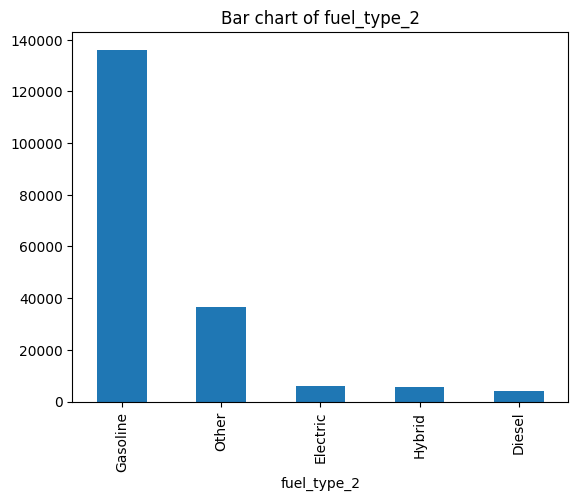

Frequency counts for ext_col:
ext_col
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
Granite Crystal Metallic Clearcoat        5
GT SILVER                                 5
Blue Caelum                               5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64


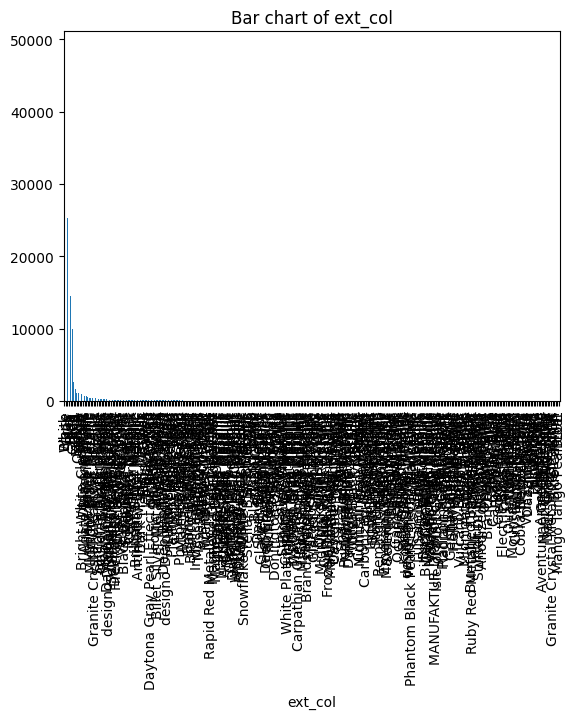

Frequency counts for int_col:
int_col
Black           107674
Beige            24495
Gray             21204
Brown             5810
Red               5145
                 ...  
Bianco Polar         7
Classic Red          7
Cobalt Blue          6
WHITE                6
ORANGE               4
Name: count, Length: 156, dtype: int64


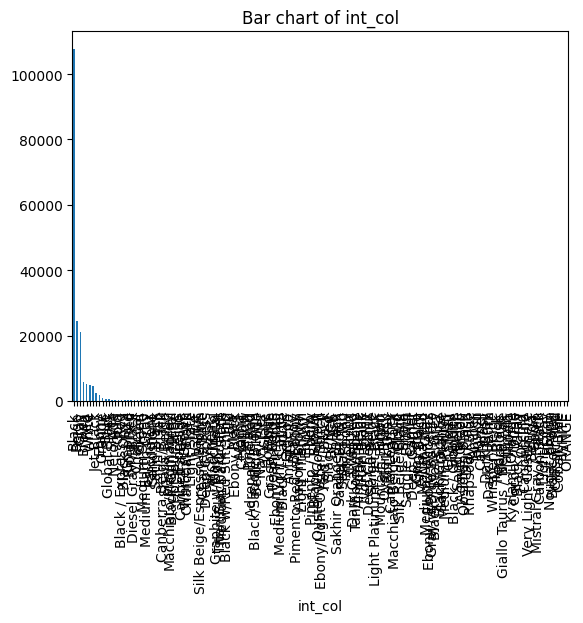

Frequency counts for engine_config:
engine_config
Other     108726
V-Type     72947
Flat        5344
Inline      1516
Name: count, dtype: int64


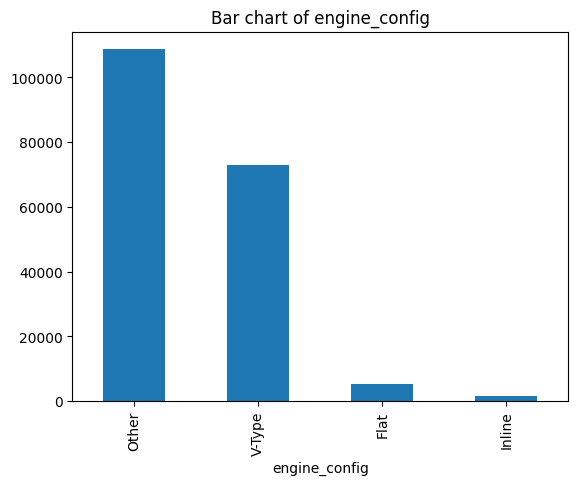

Frequency counts for transmission_type:
transmission_type
Automatic    152307
DCT           19255
Manual        16415
Other           556
Name: count, dtype: int64


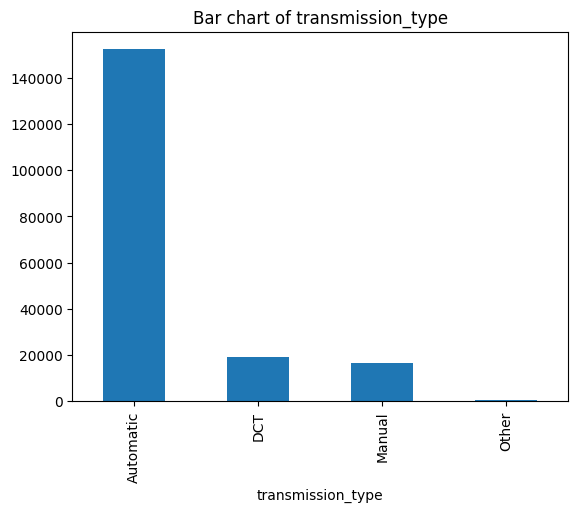

In [33]:
# Categorical Columns
for col in categorical_columns:
    print(f"Frequency counts for {col}:")
    print(cars_train_df[col].value_counts())
    cars_train_df[col].value_counts().plot(kind='bar')
    plt.title(f'Bar chart of {col}')
    plt.show()

Binary counts for vehicle_damage:
vehicle_damage
0.0    144514
1.0     41567
Name: count, dtype: int64


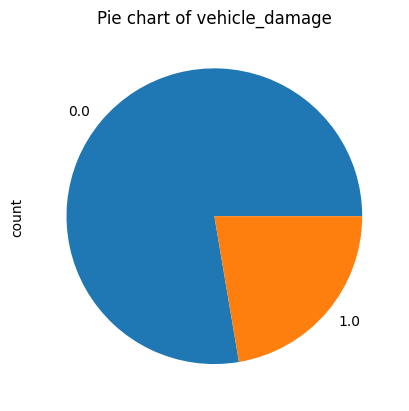

Binary counts for binary_clean_title:
binary_clean_title
1    167114
0     21419
Name: count, dtype: int64


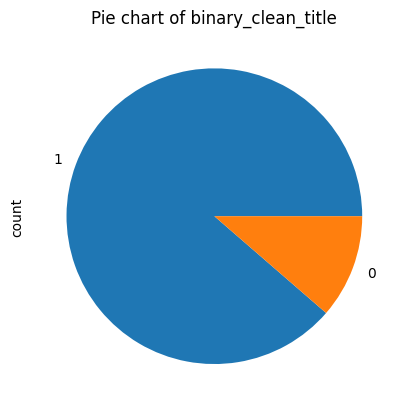

Binary counts for turbo:
turbo
0    174263
1     14270
Name: count, dtype: int64


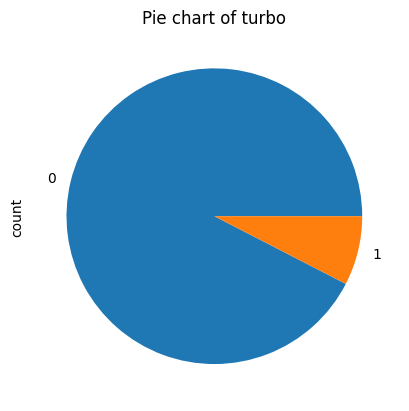

In [35]:
for col in binary_columns:
    print(f"Binary counts for {col}:")
    print(cars_train_df[col].value_counts())
    cars_train_df[col].value_counts().plot(kind='pie')
    plt.title(f'Pie chart of {col}')
    plt.show()